# TF isoform data


## TODO

- check valid clones only in all data
- get sequence information
- remove partners that didn't test positive with any isoform
- remove single isoforms
    - but need to add first to paralogs
- Look into effect of number of PPIs per TF
- combine categories to get paralog data

In [ ]:
import os
from itertools import combinations

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

import ccsblib
from ccsblib import ccsbplotlib as cplt

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_rna_expression_data,
                          load_seq_comparison_data)

%matplotlib inline

y2h = load_isoform_and_paralog_y2h_data()
y1h = load_y1h_pdi_data()
# m1h = load_m1h_activation_data()
tfs, ptrs, = load_rna_expression_data()
isoforms = load_valid_isoform_clones()
idents = load_seq_comparison_data()

tfs = tfs.drop(columns=['tpm_stdev'])
tfs = tfs.set_index(['gene', 'isoacc', 'tiss'])
tfs = tfs.unstack(level='tiss')
tfs.columns = tfs.columns.get_level_values(1)

tfs.to_csv('tf_isoform_tissue_tpms.tsv', sep='\t')

In [2]:
y2h.head()
y1h.head()
m1h.head()
rna.head()
idents.head()

iso_pairs = []
for tf_gene in isoforms['gene'].unique():
    tf_iso = isoforms.loc[isoforms['gene'] == tf_gene,
                          'clone_acc'].values
    for iso_a, iso_b in combinations(tf_iso, 2):
        iso_pairs.append((tf_gene, iso_a, iso_b))
iso_pairs = pd.DataFrame(data=iso_pairs,
                         columns=['tf_gene_symbol', 'clone_acc_a', 'clone_acc_b'])


def ppi_metric(row, data, function):
    gene_name = row['tf_gene_symbol']
    results = (data.loc[data['ad_gene_symbol'] == gene_name, :]
                   .pivot(values='score', index='db_gene_symbol', columns='ad_clone_acc'))
    ad_a = row['clone_acc_a']
    ad_b = row['clone_acc_b']
    if ad_a not in results.columns or ad_b not in results.columns:
        return np.nan
    pair = results.loc[:, [ad_a, ad_b]]
    # remove any partner with AA / NC / NS / NaN in either
    pair = pair.loc[pair.isin(['0', '1']).all(axis=1), :].astype(int).astype(bool)
    # remove partners that tested negative in both
    pair = pair.loc[pair.any(axis=1), :]
    if pair.shape[0] > 0:
        return function(set(pair.index[pair[ad_a]].values),
                        set(pair.index[pair[ad_b]].values))
    else:
        return np.nan

    
def jaccard_index(a, b):
    return len(a.intersection(b)) / float(len(a.union(b)))


def simpsons_index(a, b):
    min_size =  min(len(a), len(b))
    if min_size == 0:
        return np.nan
    else:
        return len(a.intersection(b)) / float(min_size)

    
def number_tested_partners(a, b):
    """Comes up with nan when it should be 0?"""
    return len(a.union(b))


def number_shared_partners(a, b):
    return len(a.intersection(b))


def number_min_partners(a, b):
    return min(len(a), len(b))


def min_difference(a, b):
    return min(len(a.difference(b)), len(b.difference(a)))


iso_pairs['pair'] = iso_pairs.apply(lambda x: '_'.join(sorted([x.clone_acc_a, x.clone_acc_b])), axis=1)


iso_pairs['ppi_n_tested'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=number_tested_partners,
                                            axis=1)
iso_pairs['ppi_n_shared'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=number_shared_partners,
                                            axis=1)
iso_pairs['ppi_n_min'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=number_min_partners,
                                            axis=1)
iso_pairs['ppi_n_min_diff'] = iso_pairs.apply(ppi_metric,
                                              data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                              function=min_difference,
                                              axis=1)
iso_pairs['ppi_jaccard'] = iso_pairs.apply(ppi_metric,
                                           data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                           function=jaccard_index,
                                           axis=1)
iso_pairs['ppi_simpson'] = iso_pairs.apply(ppi_metric,
                                            data=y2h.loc[y2h['category'] == 'tf_isoform_ppis', :],
                                            function=simpsons_index,
                                            axis=1)
iso_pairs['ppi_n_diff'] = iso_pairs['ppi_n_tested'] - iso_pairs['ppi_n_shared']


def fold_change_m1h(row):
    if (row['clone_acc_a'] not in m1h['clone_acc'].values or
        row['clone_acc_b'] not in m1h['clone_acc'].values):
        return np.nan
    a = m1h.loc[m1h['clone_acc'] == row['clone_acc_a'],
                [c for c in m1h.columns if c.startswith('M1H_rep')]].mean(axis=1).values[0]
    b = m1h.loc[m1h['clone_acc'] == row['clone_acc_b'],
                [c for c in m1h.columns if c.startswith('M1H_rep')]].mean(axis=1).values[0]
    return max(a, b) - min(a, b)


iso_pairs['activation_fold_change'] = iso_pairs.apply(fold_change_m1h, axis=1)

def pdi_metric(row, data, function):
    df = data.loc[(data['unique_acc'] == row['clone_acc_a']) |
                  (data['unique_acc'] == row['clone_acc_b']), 
                  data.columns[2:]].copy()
    if df.shape[0] < 2:
        return np.nan
    df = df.loc[:, df.any(axis=0)]
    if df.shape[1] == 0:
        return np.nan
    a = set(df.columns[df.iloc[0]])
    b = set(df.columns[df.iloc[1]])
    return function(a, b)


iso_pairs['pdi_n_tested'] = iso_pairs.apply(pdi_metric,
                                            data=y1h,
                                            function=number_tested_partners,
                                            axis=1)
iso_pairs['pdi_n_shared'] = iso_pairs.apply(pdi_metric,
                                            data=y1h,
                                            function=number_shared_partners,
                                            axis=1)
iso_pairs['pdi_n_min'] = iso_pairs.apply(pdi_metric,
                                            data=y1h,
                                            function=number_min_partners,
                                            axis=1)
iso_pairs['pdi_n_min_diff'] = iso_pairs.apply(pdi_metric,
                                              data=y1h,
                                              function=min_difference,
                                              axis=1)
iso_pairs['pdi_jaccard'] = iso_pairs.apply(pdi_metric,
                                           data=y1h,
                                           function=jaccard_index,
                                           axis=1)
iso_pairs['pdi_simpson'] = iso_pairs.apply(pdi_metric,
                                            data=y1h,
                                            function=simpsons_index,
                                            axis=1)
iso_pairs['pdi_n_diff'] = iso_pairs['pdi_n_tested'] - iso_pairs['pdi_n_shared']

In [234]:
# Add in the aa sequence similarity info. for iso_pairs table.
iso_pairs = iso_pairs.merge(seq_ident, how='left', on='pair')

In [235]:
iso_pairs.head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,activation_fold_change,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,aa_seq_perc_ident
0,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,AEBP2|2/3|05F03_AEBP2|3/3|05E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.0
1,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,ARNT2|1/6|08C12_ARNT2|2/6|09E01,9.0,5.0,5.0,0.0,0.555556,1.0,4.0,2.094800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0
2,ARNT2,ARNT2|1/6|08C12,ARNT2|3/6|10D11,ARNT2|1/6|08C12_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.7
3,ARNT2,ARNT2|2/6|09E01,ARNT2|3/6|10D11,ARNT2|2/6|09E01_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.1
4,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,ARNTL|1/2|08H08_ARNTL|2/2|08E08,2.0,0.0,0.0,0.0,0.000000,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.3


### Explore PDI/PPI profile differences and sequence similarity

Look into:
- PPI and PDI Jaccard distribution
  - Faceted by degree
- PPI versus PDI Jaccard/Simpson
  - Faceted by number of interactors
- PPI/PDI Jaccard versus sequence similarity

TODO
- Compare randomly selected isoforms from different genes (from paralog data)

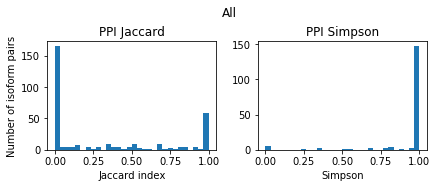

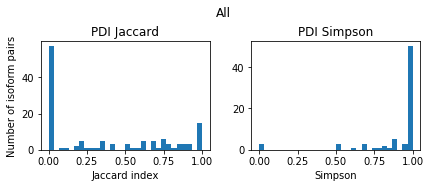

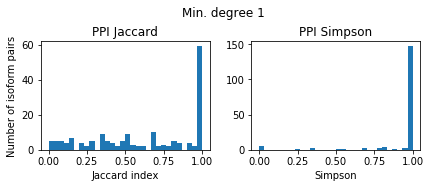

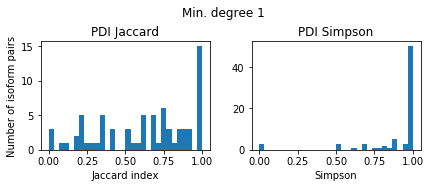

In [304]:
#  Jaccard/Simpson for PPI/PDI, histograms
def make_jaccard_simpson_hist(int_type, iso_pairs=iso_pairs, main_title='', nb=30):
    # int_type - ppi or pdi
    # nb - number of bins
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2.5))
    fig.suptitle(main_title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.87]) # adjust to allow for subtitle

    ax1.hist(iso_pairs[int_type + '_jaccard'], bins=nb)
    ax1.set_title(int_type.upper() + ' Jaccard')
    ax1.set_xlabel('Jaccard index')
    ax1.set_ylabel('Number of isoform pairs')
    
    ax2.hist(iso_pairs[int_type + '_simpson'], bins=nb)
    ax2.set_title(int_type.upper() + ' Simpson')
    ax2.set_xlabel('Simpson')
    
make_jaccard_simpson_hist('ppi', iso_pairs, 'All')
make_jaccard_simpson_hist('pdi', iso_pairs, 'All')
make_jaccard_simpson_hist('ppi', iso_pairs.loc[iso_pairs['ppi_n_min']>=1, :], main_title='Min. degree 1')
make_jaccard_simpson_hist('pdi', iso_pairs.loc[iso_pairs['pdi_n_min']>=1, :], main_title='Min. degree 1')


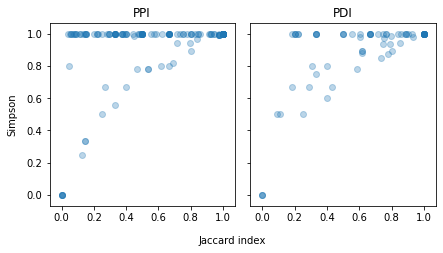

In [229]:
# Jaccard vs Simpson for PPI and PDI
def make_jaccard_simpson_plot(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

    alpha=0.3
    ax1.scatter(df.ppi_jaccard, df.ppi_simpson, alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_aspect('equal')
    ax2.scatter(df.pdi_jaccard, df.pdi_simpson, alpha=alpha)
    ax2.set_title('PDI')
    ax2.set_aspect('equal')

    fig.tight_layout()
    fig.text(0.5, 0.05, 'Jaccard index', ha='center')
    fig.text(-0.02, 0.5, 'Simpson', va='center', rotation='vertical')

make_jaccard_simpson_plot(iso_pairs) # only plotted for cases  with 1+ interactions for both iso. of a pair

SpearmanrResult(correlation=nan, pvalue=nan)

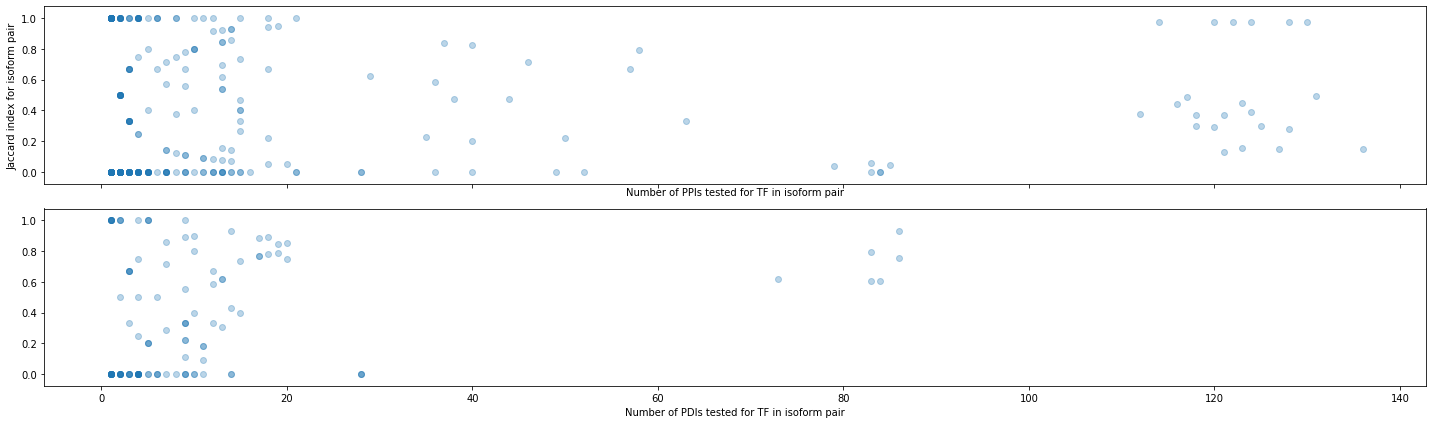

In [321]:
# Is there a relationship between degree and interaction profile similarity?
# For now use number of pdi/ppi tested as estimate of degree.
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(20,6))
alpha=0.3

ax1.scatter(iso_pairs.ppi_n_tested, iso_pairs.ppi_jaccard, alpha=alpha)
ax1.set_xlabel('Number of PPIs tested for TF in isoform pair')
ax1.set_ylabel('Jaccard index for isoform pair')

ax2.scatter(iso_pairs.pdi_n_tested, iso_pairs.pdi_jaccard, alpha=alpha)
ax2.set_xlabel('Number of PDIs tested for TF in isoform pair')

fig.tight_layout()

# Luke question - how to determine if there is no bias between degree and Jaccard?
stats.spearmanr(iso_pairs.ppi_n_tested, iso_pairs.ppi_jaccard)
stats.spearmanr(iso_pairs.pdi_n_tested, iso_pairs.pdi_jaccard)

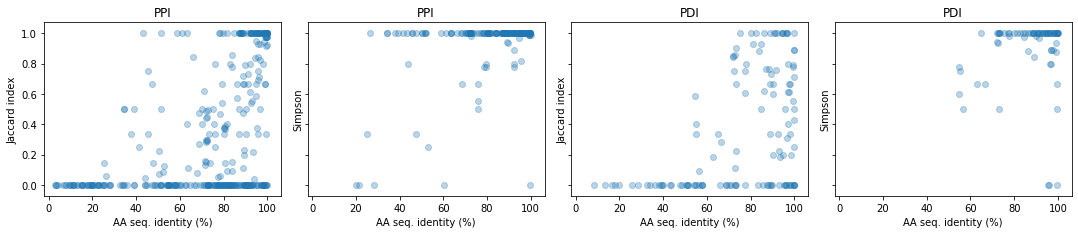

In [266]:
# Jaccard/Simpson versus similarity for PPI and PDI
def make_profile_diff_vs_seq_plot(df):
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(15,3))
    fig.tight_layout()
    (ax1, ax2, ax3, ax4) = axs
    
    for ax in axs: ax.set_xlabel('AA seq. identity (%)')
        
    alpha=0.3
    
    ax1.scatter(df.aa_seq_perc_ident, df.ppi_jaccard, alpha=alpha)
    ax1.set_title('PPI')
    ax1.set_ylabel('Jaccard index')
    ax2.scatter(df.aa_seq_perc_ident, df.ppi_simpson, alpha=alpha)
    ax2.set_title('PPI')
    ax2.set_ylabel('Simpson')
    ax3.scatter(df.aa_seq_perc_ident, df.pdi_jaccard, alpha=alpha)
    ax3.set_title('PDI')
    ax3.set_ylabel('Jaccard index')
    ax4.scatter(df.aa_seq_perc_ident, df.pdi_simpson, alpha=alpha)
    ax4.set_title('PDI')
    ax4.set_ylabel('Simpson')

make_profile_diff_vs_seq_plot(iso_pairs)

Text(27.125, 0.5, 'M1H activation fold change')

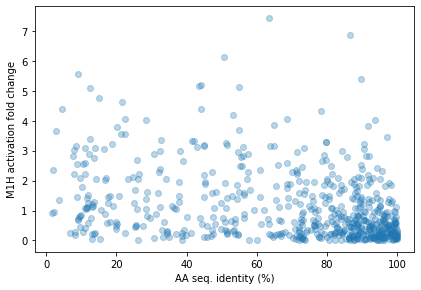

In [271]:
# Jaccard/Simpson versus similarity for M1H
fig, ax1 = plt.subplots(1, sharex=True, sharey=True)
fig.tight_layout()
alpha=0.3
ax1.scatter(iso_pairs.aa_seq_perc_ident, iso_pairs.activation_fold_change, alpha=alpha)
ax1.set_xlabel('AA seq. identity (%)')
ax1.set_ylabel('M1H activation fold change')

In [78]:
# get isoform-specific y1h and y2h degree
deg = y1h.loc[:, y1h.columns[2:]].sum(axis=1).rename('y1h_degree')
y1h_nd = y1h[['tf', 'unique_acc']].join(deg, how='left')
y2h_nd = y2h.loc[y2h.category=='tf_isoform_ppis', :].groupby('ad_clone_acc')['ad_clone_acc'].count().rename('y2h_degree')
int_nd = y1h_nd.join(y2h_nd, how='outer', on='unique_acc')
int_nd

,tf,unique_acc,y1h_degree,y2h_degree
162.0,CREB1,CREB1|1/2|02E01,0.0,1.0
0.0,CREB1,CREB1|2/2|01F12,3.0,1.0
1.0,DLX1,DLX1|1/2|07A12,9.0,NaN
174.0,DLX1,DLX1|2/2|07E09,0.0,NaN
2.0,DLX4,DLX4|1/3|11A04,3.0,1.0
...,...,...,...,...
NaN,NaN,ZSCAN32|1/5|05B06,NaN,7.0
NaN,NaN,ZSCAN32|2/5|05F05,NaN,7.0
NaN,NaN,ZSCAN32|4/5|05H04,NaN,7.0
NaN,NaN,ZSCAN9|1/3|11H08,NaN,13.0


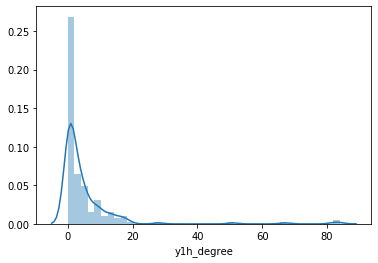

In [86]:
# plot the degree distributions
# degere of y1h
sns.distplot(int_nd.y1h_degree.dropna()) 

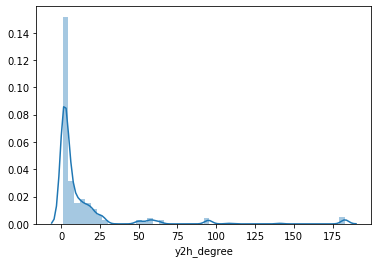

In [87]:
# plot the degree distributions
# degere of y2h
sns.distplot(int_nd.y2h_degree.dropna()) 

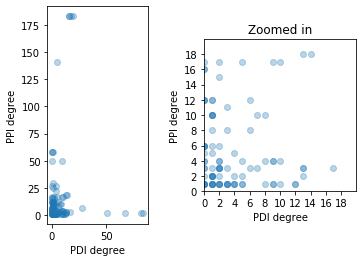

In [391]:
# compare pdi versus ppi degree
fig, (ax1, ax2) = plt.subplots(1,2)
alpha = 0.3

ax1.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax1.set_aspect('equal')
ax1.set_xlabel('PDI degree')
ax1.set_ylabel('PPI degree')

ax2.scatter(int_nd.y1h_degree, int_nd.y2h_degree, alpha=alpha)
ax2.set_aspect('equal')
ax2.set_xlabel('PDI degree')
ax2.set_ylabel('PPI degree')
ax2.set_title('Zoomed in')
ax2.set_xlim(0,20)
ax2.set_xticks(range(0,20,2))
ax2.set_ylim(0,20)
ax2.set_yticks(range(0,20,2))
# ax2.set_yscale('log')
# ax2.set_xscale('log')


In [ ]:
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
plt.scatter(xy[x], xy[y])
stats.spearmanr(xy[x], xy[y])

In [ ]:
x = 'pdi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y])
stats.spearmanr(xy[x], xy[y])

In [ ]:
x = 'pdi_jaccard'
y = 'ppi_jaccard'
xy = iso_pairs.loc[iso_pairs[x].notnull() & iso_pairs[y].notnull(), :]
print(xy.shape)
plt.scatter(xy[x], xy[y],
            alpha=0.3)
stats.spearmanr(xy[x], xy[y])

In [7]:
# Look at direction of activation change? I.e. is the isoform with less binding partners
# the one with activation closer to 0?

In [9]:
iso_pairs.sort_values('ppi_n_min_diff',
                      ascending=False).head(20)

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpsons,ppi_n_diff,activation_fold_change
644,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|4/9|10H06,ZBTB44|1/9|12B06_ZBTB44|4/9|10H06,15.0,5.0,9.0,4.0,0.333333,0.555556,10.0,1.324958
354,PATZ1,PATZ1|1/4|02C02,PATZ1|3/4|02A04,PATZ1|1/4|02C02_PATZ1|3/4|02A04,18.0,12.0,15.0,3.0,0.666667,0.800000,6.0,1.239169
513,TCF4,TCF4|5/9|07C02,TCF4|7/9|07G03,TCF4|5/9|07C02_TCF4|7/9|07G03,58.0,46.0,49.0,3.0,0.793103,0.938776,12.0,2.090708
645,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|5/9|10H05,ZBTB44|1/9|12B06_ZBTB44|5/9|10H05,15.0,6.0,9.0,3.0,0.400000,0.666667,9.0,1.493713
811,ZNF451,ZNF451|6/8|05H11,ZNF451|7/8|06D01,ZNF451|6/8|05H11_ZNF451|7/8|06D01,8.0,1.0,4.0,3.0,0.125000,0.250000,7.0,1.485041
587,TFEC,TFEC|2/6|04A02,TFEC|5/6|04A01,TFEC|2/6|04A02_TFEC|5/6|04A01,5.0,0.0,2.0,2.0,0.000000,0.000000,5.0,NaN
514,TCF4,TCF4|5/9|07C02,TCF4|8/9|07A05,TCF4|5/9|07C02_TCF4|8/9|07A05,46.0,33.0,35.0,2.0,0.717391,0.942857,13.0,1.825006
643,ZBTB44,ZBTB44|1/9|12B06,ZBTB44|3/9|10B06,ZBTB44|1/9|12B06_ZBTB44|3/9|10B06,15.0,7.0,9.0,2.0,0.466667,0.777778,8.0,1.525376
655,ZBTB44,ZBTB44|3/9|10B06,ZBTB44|6/9|12H02,ZBTB44|3/9|10B06_ZBTB44|6/9|12H02,13.0,9.0,11.0,2.0,0.692308,0.818182,4.0,0.080167
801,ZNF451,ZNF451|3/8|06A03,ZNF451|6/8|05H11,ZNF451|3/8|06A03_ZNF451|6/8|05H11,7.0,1.0,3.0,2.0,0.142857,0.333333,6.0,0.201770


In [9]:
y2h.loc[y2h['category'] == 'tf_isoform_ppis', 'ad_gene_symbol'].nunique()

164

In [10]:
# Plot degree of binding partners vs. fraction of isoforms interacting

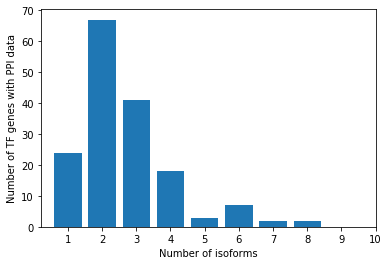

In [11]:
#    - Number of isoforms per TF gene

# remove isoform counts of 1?
n_iso = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').nunique()['ad_clone_acc']
fig, ax = plt.subplots(1, 1)
ax.bar(n_iso.value_counts().index,
       n_iso.value_counts().values)
ax.set_xticks(range(1, 11))
ax.set_xlabel('Number of isoforms')
ax.set_ylabel('Number of TF genes with PPI data');

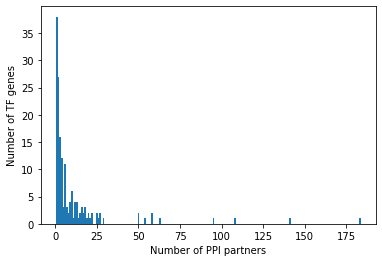

In [12]:
#    - Number of partners per TF gene

n_ppi = y2h.loc[y2h['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol').nunique()['db_gene_symbol']
fig, ax = plt.subplots(1, 1)
ax.hist(n_ppi.values, range=(0.5, n_ppi.max() + 0.5), bins=n_ppi.max())
ax.set_xlabel('Number of PPI partners')
ax.set_ylabel('Number of TF genes');

In [13]:
#    - How many isoforms have 0 interactions?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'ad_clone_acc'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'ad_clone_acc'].nunique()
print('Of {} isoforms, {} have at least one positive interation'.format(a, b))

Of 440 isoforms, 242 have at least one positive interation


In [14]:
#    - How many partners were negative in all pairwise tests?
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].nunique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].nunique()
print('Of {} tested partners, {} had at least one positive result'.format(a, b))

Of 914 tested partners, 728 had at least one positive result


In [15]:
a = y2h.loc[(y2h['category'] == 'tf_isoform_ppis'),
           'db_gene_symbol'].unique()
b = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
           (y2h['score'] == '1'),
           'db_gene_symbol'].unique()
c = set(a).difference(set(b))

In [16]:
# remove these interactions where none of the isoforms are 
y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
        y2h['db_gene_symbol'].isin(c), :].head()

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score
57,tf_isoform_ppis,101216,GATA1|1/2|08A02,GATA1,1579,TEKT4,0
103,tf_isoform_ppis,100301,SMAD3|1/4|06A07,SMAD3,1579,TEKT4,0
115,tf_isoform_ppis,100697,SMAD3|4/4|06F07,SMAD3,1579,TEKT4,0
126,tf_isoform_ppis,100657,SMAD3|2/4|06G07,SMAD3,1579,TEKT4,0
138,tf_isoform_ppis,100479,SMAD3|3/4|06B08,SMAD3,1579,TEKT4,0


In [17]:
def isoform_display_name(s):
       """Convert clone accession ID to display friendly format"""
       return s.split('|')[0] + '-' + s.split('|')[1].split('/')[0]

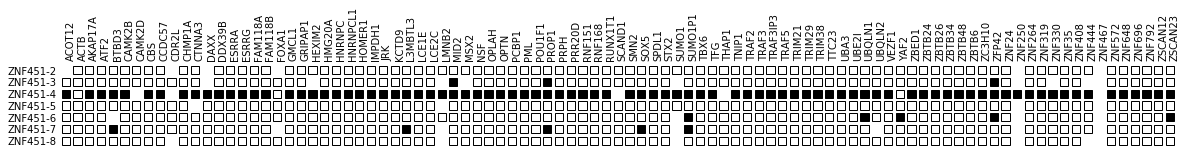

In [18]:
def y2h_ppi_per_tf_gene_plot(gene_name, 
                             data,
                             ax=None, 
                             min_n_isoforms=1,
                             min_n_partners=1):
    tf = data.loc[(data['category'] == 'tf_isoform_ppis') &
                (data['ad_gene_symbol'] == gene_name),
                ['ad_clone_acc', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf['ad_clone_acc'] = tf['ad_clone_acc'].apply(isoform_display_name)
    tf = tf.pivot(index='ad_clone_acc',
                  columns='db_gene_symbol',
                  values='score')
    if ax is None:
        ax = plt.gca()
    if tf.shape[0] < min_n_isoforms or tf.shape[1] < min_n_partners:
        ax.set_axis_off()
        ax.text(0.5, 0.5,
                'No PPI data available',
                ha='center', va='center',
                fontsize=30,
                fontweight='bold',
                color='grey')
        return
    cplt.binary_profile_matrix(tf, ax=ax, column_label_rotation=90)
    
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
gene_name = 'ZNF451'
y2h_ppi_per_tf_gene_plot(gene_name, data=y2h)

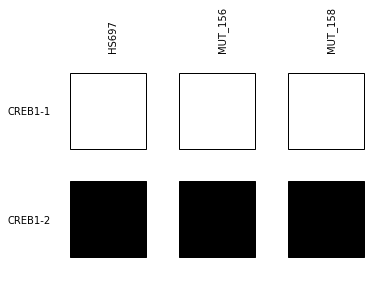

In [19]:
def y1h_pdi_per_tf_gene_plot(gene_name, 
                             data,
                             ax=None,
                             min_n_isoforms=1,
                             min_n_partners=1):
    tf = data.loc[data['tf'] == gene_name,
                  data.columns[1:]].copy().set_index('unique_acc')
    tf.index = tf.index.map(isoform_display_name)
    tf = tf.loc[:, tf.any(axis=0)]
    if ax is None:
        ax = plt.gca()
    if tf.shape[0] < min_n_isoforms or tf.shape[1] < min_n_partners:
        ax.set_axis_off()
        ax.text(0.5, 0.5,
                'No PDI data available',
                ha='center', va='center',
                fontsize=30,
                fontweight='bold',
                color='grey')
        return
    cplt.binary_profile_matrix(tf, ax=ax, column_label_rotation=90)


y1h_pdi_per_tf_gene_plot('CREB1', y1h)

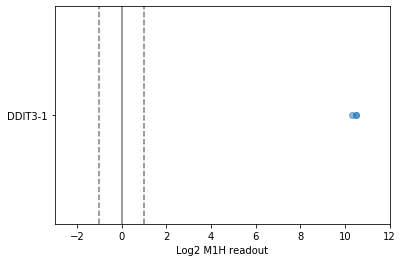

In [20]:
def m1h_activation_per_tf_gene_plot(tf_gene_name, data, ax=None):
    if ax is None:
        ax = plt.gca()
    if tf_gene_name not in data['gene'].values:
        ax.set_axis_off()
        ax.text(0.5, 0.5,
                'No activation data available',
                ha='center', va='center',
                fontsize=30,
                fontweight='bold',
                color='grey')
        return
    rep_columns = [c for c in data.columns if c.startswith('M1H_rep')]
    ax.scatter(
        y=[isoform_display_name(acc) for acc in data.loc[data['gene'] == tf_gene_name, 'clone_acc'].values
           for __ in range(len(rep_columns))],
        x=data.loc[data['gene'] == tf_gene_name, rep_columns].values.flatten(),
        alpha=0.5
        )
    ax.set_xlim(-3, 12)
    ax.set_xlabel('Log2 M1H readout')
    ax.axvline(0, linestyle='-', color='grey')
    ax.axvline(-1, linestyle='--', color='grey')
    ax.axvline(1, linestyle='--', color='grey')
    ax.invert_yaxis()
    
    
m1h_activation_per_tf_gene_plot('DDIT3', data=m1h)

FileNotFoundError: [Errno 2] No such file or directory: 'data/hTFIso6K_valid_isoforms/j2_6k_unique_isoacc_and_nt_seqs.fa'

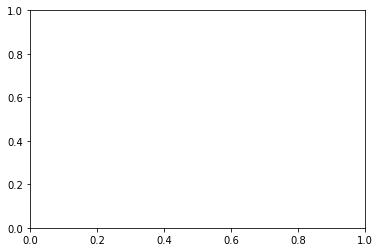

In [21]:
from isomodules import isocreate, isoimage, isofunc


def isoform_box_and_line_drawing(gene_name, ax=None):
    if ax is None:
        ax = plt.gca()
    path_6k_gtf = 'data/hTFIso6K_valid_isoforms/c_6k_unique_acc_aligns.gtf'
    path_6k_fa = 'data/hTFIso6K_valid_isoforms/j2_6k_unique_isoacc_and_nt_seqs.fa'
    orf_seqs_6k = isofunc.oc_fasta_to_orf_seq_dict(path_6k_fa)
    gd = isocreate.init_gen_obj(path_6k_gtf, [gene_name])
    gd = isocreate.create_and_link_seq_related_obj(gd, orf_seqs_6k)
    isoimage.render_iso_image(list(gd[gene_name].orfs), ax=ax)


isoform_box_and_line_drawing('STAT1')

In [ ]:
def tf_gene_summary_plot(gene_name):
    """
    
    - add missing data to Y1H and M1H so that the number of isoforms lines up between each plot

    """
    n_iso_y2h = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                        (y2h['ad_gene_symbol'] == gene_name),
                        'ad_clone_acc'].nunique()
    n_partner_y2h = y2h.loc[(y2h['category'] == 'tf_isoform_ppis') &
                            (y2h['ad_gene_symbol'] == gene_name),
                            'db_gene_symbol'].nunique()
    n_iso_y1h = (y1h['tf'] == gene_name).sum()
    n_partner_y1h = y1h.loc[(y1h['tf'] == gene_name), y1h.columns[2:]].any(axis=0).sum()
    fig, axes = plt.subplots(4, 1)
    fig.set_size_inches(max(7, n_partner_y2h * 0.2, n_partner_y2h * 0.2),
                        max(20, n_iso_y2h * 0.2, n_iso_y1h * 0.2))
    
    isoform_box_and_line_drawing(gene_name, ax=axes[0])
    y2h_ppi_per_tf_gene_plot(gene_name, data=y2h, ax=axes[1])
    y1h_pdi_per_tf_gene_plot(gene_name, data=y1h, ax=axes[2])
    m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=axes[3])
    os.makedirs('figures/per_tf_gene', exist_ok=True)
    plt.savefig('figures/per_tf_gene/' + gene_name + '_summary.pdf',
                bbox_inches='tight')
    plt.close(fig)


for gene in isoforms['gene'].unique():
    tf_gene_summary_plot(gene)

In [ ]:
# Check if this result is robust against requiring at least
# one interaction partner for both genes.
# To see if the effect is driven by non-functional isoforms.
x = 'ppi_jaccard'
y = 'activation_fold_change'
xy = iso_pairs.loc[iso_pairs[x].notnull() &
                   iso_pairs[y].notnull() &
                   (iso_pairs['ppi_n_min'] >= 1), :]
print(xy.shape)
stats.spearmanr(xy[x], xy[y])

In [ ]:
xy.sort_values('activation_fold_change', ascending=False).head()